In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import sys
sys.path.append('/home/chenani/ownCloud/Workspaces/Eclipse/dataAnalysis/Sleep-current/src/')

In [2]:
%matplotlib 
#inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as pl
import numpy as np
import pickle as pkl
import os
import seaborn as sns
import pandas as pd
import fnmatch
from scipy.stats import binom_test

Using matplotlib backend: Qt4Agg


/home/chenani/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
def locate(pattern, root=os.curdir):
    '''Locate all files matching supplied filename pattern in and below
        supplied root directory.
    '''
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            yield [path,filename]
def findClosestPoint(values,array):
    values = np.array(values)
    array = np.array(array)
    idx = np.array([np.square(array - value).argmin() for value in values])
    return idx,array[idx]
def sigCounter(df,min_N = 3):
    dbMinN = df[(df.lSub>min_N)|(df.rSub>min_N)]
    nT = dbMinN.shape[0]
    nS = df[(df.Lpv<0.05)|(df.Rpv<0.05)].shape[0]
    print nT,nS,binom_test(nS,nT,0.05)
    print 1e2*nS/nT
sns.set_style('white')

In [4]:
dataFolder = '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/lesion/Rat434Lesion/'

In [5]:
asleepDBs = sorted([os.path.join(item[0],item[1])for item in locate('*pop*.db',dataFolder)])
awakeDBs  = sorted([os.path.join(item[0],item[1])for item in locate('*awake*.db',dataFolder)])
asleepDBs,awakeDBs

(['/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/lesion/Rat434Lesion/dataFiles/sleepDB/434-popDB-D1.db'],
 ['/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/lesion/Rat434Lesion/dataFiles/awakeReplays-434-D1-PR.db',
  '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/lesion/Rat434Lesion/dataFiles/awakeReplays-434-D1-RO.db',
  '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/lesion/Rat434Lesion/dataFiles/awakeReplays-434-D1.db'])

In [55]:
corrBinsPR = np.arange(-1.05,1.15,0.05)
corrBinsCentersPR = (corrBinsPR+0.025)[:-1]
surrProbs = []
for n in range(4,11):
    crr = pkl.load(open('/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/RankOrder/corr'+str(n)+'.crr','rb'))
    hst = np.histogram(crr,corrBinsPR,normed=True)[0]
    surrProbs.append(hst)
#################################
for dbFile in asleepDBs:
    asleepDF = pd.read_pickle(dbFile)
    print asleepDF.date[0]
    for sess in ['sleep05','sleep06']:
        df = asleepDF[asleepDF.session==sess]
        print sess,df.shape
        for n in range(4,11):
            #print n
            #print '----------------'
            dfLsub = df[df.lSub==n]
            dfRsub = df[df.rSub==n]
            hstL = np.histogram(dfLsub.Lcorr,corrBinsPR)[0]
            hstR = np.histogram(dfRsub.Rcorr,corrBinsPR)[0]
            for item in np.where(hstL)[0]:
                p_value = binom_test(hstL[item],hstL.sum(),surrProbs[n-4][item]*0.05)
                if p_value < 0.05:
                    idxs = np.where(np.abs(findClosestPoint(dfLsub.Lcorr,corrBinsCentersPR)[1]- corrBinsCentersPR[item])<0.01)[0]
                    locs = dfLsub.index[idxs]
                    asleepDF.Lpv[locs] += (p_value-1)
            for item in np.where(hstR)[0]:
                p_value = binom_test(hstR[item],hstR.sum(),surrProbs[n-4][item]*0.05)
                if p_value < 0.05:
                    idxs = np.where(np.abs(findClosestPoint(dfRsub.Rcorr,corrBinsCentersPR)[1]- corrBinsCentersPR[item])<0.01)[0]
                    locs = dfRsub.index[idxs]
                    asleepDF.Rpv[locs] += (p_value-1)

            #print '##############################################################################'
        ###################################################################################
        #print '10++'
        dfLsub = df[df.lSub>10]
        dfRsub = df[df.rSub>10]
        hstL = np.histogram(dfLsub.Lcorr,corrBinsPR)[0]
        hstR = np.histogram(dfRsub.Rcorr,corrBinsPR)[0]
        for item in np.where(hstL)[0]:
            #print hstL[item],corrBinsCenters[item]
            p_value = binom_test(hstL[item],hstL.sum(),surrProbs[-1][item]*0.05)
            if p_value < 0.05:
                #print corrBinsCenters[item],p_value
                idxs = np.where(np.abs(findClosestPoint(dfLsub.Lcorr,corrBinsCentersPR)[1]- corrBinsCentersPR[item])<0.01)[0]
                locs = dfLsub.index[idxs]
                asleepDF.Lpv[locs] += (p_value-1)
        #print '####################'
        for item in np.where(hstR)[0]:
            #print hstR[item],corrBinsCenters[item]
            p_value = binom_test(hstR[item],hstR.sum(),surrProbs[-1][item]*0.05)
            if p_value < 0.05:
                idxs = np.where(np.abs(findClosestPoint(dfRsub.Rcorr,corrBinsCentersPR)[1]- corrBinsCentersPR[item])<0.01)[0]
                locs = dfRsub.index[idxs]
                asleepDF.Rpv[locs] += (p_value-1)
#        asleepDF.to_pickle(dbFile.split('-')[0]+'-prDB-'+ dbFile.split('-')[-1])

binwidth = 0.1
A = np.linspace(0,1.,1.0/binwidth+1)
binwidth = np.diff(A)[0]
corrBinsCenters = np.union1d(-1*A,A)
corrBins = corrBinsCenters-binwidth/2
corrBins = np.insert(corrBins,[corrBins.size],[corrBins[-1]+binwidth])
##########################################
surrProbs = []
for n in range(4,11):
    crr = pkl.load(open('/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/RankOrder/corr'+str(n)+'.crr','rb'))
    hst = np.histogram(crr,corrBins,normed=True)[0]
    surrProbs.append(hst)
idx = [findClosestPoint([0.025],binwidth*np.cumsum(surrProbs[n-5]))[0] for n in range(5,11)]
SigCorrMin = [np.abs(corrBinsCenters[ii+1][0]) for ii in idx]
#################################
for dbFile in asleepDBs:
    asleepDF = pd.read_pickle(dbFile)
    print asleepDF.date[0]
    for sess in ['sleep05','sleep06']:
        df = asleepDF[asleepDF.session==sess]
        for idx,row in df.iterrows():
            if row.lSub>4:
                if np.abs(row.Lcorr) > SigCorrMin[min(int(row.lSub - 5),len(SigCorrMin)-1)]:
                    asleepDF.Lpv[idx]-=0.96
            if row.rSub>4:
                if np.abs(row.Rcorr) > SigCorrMin[min(int(row.rSub - 5),len(SigCorrMin)-1)]:
                    asleepDF.Rpv[idx]-=0.96
#    asleepDF.to_pickle(dbFile.split('-')[0]+'-roDB-'+ dbFile.split('-')[-1])
            

/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:57: SettingWithCopyWarning: 
A value is trying to be s

Day1
sleep05 (1007, 15)
sleep06 (891, 15)
Day1

/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:61: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
corrBinsPR = np.arange(-1.05,1.15,0.05)
corrBinsCentersPR = (corrBinsPR+0.025)[:-1]
surrProbs = []
for n in range(4,11):
    crr = pkl.load(open('/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/RankOrder/corr'+str(n)+'.crr','rb'))
    hst = np.histogram(crr,corrBinsPR,normed=True)[0]
    surrProbs.append(hst)
#################################
for dbFile in awakeDBs:
    awakeDF = pd.read_pickle(dbFile)
    df = awakeDF.copy()
    for n in range(4,11):
        dfLsub = df[df.lSub==n]
        dfRsub = df[df.rSub==n]
        hstL = np.histogram(dfLsub.Lcorr,corrBinsPR)[0]
        hstR = np.histogram(dfRsub.Rcorr,corrBinsPR)[0]
        for item in np.where(hstL)[0]:
            p_value = binom_test(hstL[item],hstL.sum(),surrProbs[n-4][item]*0.05)
            if p_value < 0.05:
                idxs = np.where(np.abs(findClosestPoint(dfLsub.Lcorr,corrBinsCentersPR)[1]- corrBinsCentersPR[item])<0.01)[0]
                locs = dfLsub.index[idxs]
                awakeDF.Lpv[locs] += (p_value-1)
        for item in np.where(hstR)[0]:
            p_value = binom_test(hstR[item],hstR.sum(),surrProbs[n-4][item]*0.05)
            if p_value < 0.05:
                idxs = np.where(np.abs(findClosestPoint(dfRsub.Rcorr,corrBinsCentersPR)[1]- corrBinsCentersPR[item])<0.01)[0]
                locs = dfRsub.index[idxs]
                awakeDF.Rpv[locs] += (p_value-1)

    dfLsub = df[df.lSub>10]
    dfRsub = df[df.rSub>10]
    hstL = np.histogram(dfLsub.Lcorr,corrBinsPR)[0]
    hstR = np.histogram(dfRsub.Rcorr,corrBinsPR)[0]
    for item in np.where(hstL)[0]:
        #print hstL[item],corrBinsCenters[item]
        p_value = binom_test(hstL[item],hstL.sum(),surrProbs[-1][item]*0.05)
        if p_value < 0.05:
            #print corrBinsCenters[item],p_value
            idxs = np.where(np.abs(findClosestPoint(dfLsub.Lcorr,corrBinsCentersPR)[1]- corrBinsCentersPR[item])<0.01)[0]
            locs = dfLsub.index[idxs]
            awakeDF.Lpv[locs] += (p_value-1)
    for item in np.where(hstR)[0]:
        p_value = binom_test(hstR[item],hstR.sum(),surrProbs[-1][item]*0.05)
        if p_value < 0.05:
            idxs = np.where(np.abs(findClosestPoint(dfRsub.Rcorr,corrBinsCentersPR)[1]- corrBinsCentersPR[item])<0.01)[0]
            locs = dfRsub.index[idxs]
            awakeDF.Rpv[locs] += (p_value-1)
    #awakeDF.to_pickle(dbFile.split('.')[0]+'-PR.db')
##############################################################################################################################################
binwidth = 0.1
A = np.linspace(0,1.,1.0/binwidth+1)
binwidth = np.diff(A)[0]
corrBinsCenters = np.union1d(-1*A,A)
corrBins = corrBinsCenters-binwidth/2
corrBins = np.insert(corrBins,[corrBins.size],[corrBins[-1]+binwidth])
##########################################
surrProbs = []
for n in range(4,11):
    crr = pkl.load(open('/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/RankOrder/corr'+str(n)+'.crr','rb'))
    hst = np.histogram(crr,corrBins,normed=True)[0]
    surrProbs.append(hst)
idx = [findClosestPoint([0.025],binwidth*np.cumsum(surrProbs[n-5]))[0] for n in range(5,11)]
SigCorrMin = [np.abs(corrBinsCenters[ii+1][0]) for ii in idx]
#################################
for dbFile in awakeDBs:
    awakeDF = pd.read_pickle(dbFile)
    df = awakeDF.copy()
    for idx,row in df.iterrows():
        if row.lSub>4:
            if np.abs(row.Lcorr) > SigCorrMin[min(int(row.lSub - 5),len(SigCorrMin)-1)]:
                awakeDF.Lpv[idx]-=0.96
        if row.rSub>4:
            if np.abs(row.Rcorr) > SigCorrMin[min(int(row.rSub - 5),len(SigCorrMin)-1)]:
                awakeDF.Rpv[idx]-=0.96
    #awakeDF.to_pickle(dbFile.split('.')[0]+'-RO.db')

/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:51: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


In [117]:
sigCounter(asleepDF)

1954 72 0.00686033053494
3.68474923234


In [118]:
awakeDF[(awakeDF.Lpv<0.05)|(awakeDF.Rpv<0.054)].shape

(50, 11)

(-1.05, 1.05)

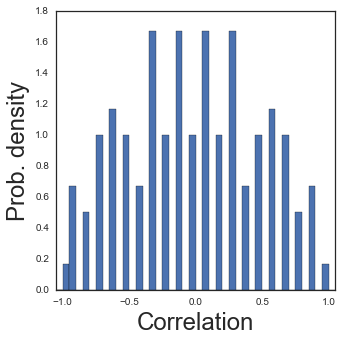

In [41]:
f,ax = pl.subplots(1,1,figsize=[5,5])
corrBinsPR = np.arange(-1.05,1.15,0.05)
corrBinsCentersPR = (corrBinsPR+0.025)[:-1]
crr = pkl.load(open('/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/RankOrder/corr5.crr','rb'))
crr9 = pkl.load(open('/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/RankOrder/corr9.crr','rb'))
ax.hist(crr,corrBinsPR,normed=True);
ax.set_ylabel('Prob. density',fontsize=24)
ax.set_xlabel('Correlation',fontsize=24)
pl.xlim(-1.05,1.05)

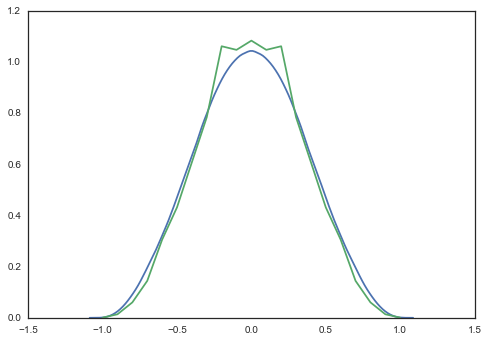

In [27]:
#sns.kdeplot(crr)
sns.kdeplot(crr9)
pl.plot(corrBinsCenters,surrProbs[-1])

In [19]:
f,ax = pl.subplots(1,1)
binwidth = 0.1
A = np.linspace(0,1.,1.0/binwidth+1)
binwidth = np.diff(A)[0]
corrBinsCenters = np.union1d(-1*A,A)
corrBins = corrBinsCenters-binwidth/2
corrBins = np.insert(corrBins,[corrBins.size],[corrBins[-1]+binwidth])
#print corrBinsCenters
##########################################
surrProbs = []
ax.axhline(0.96,linewidth=1,color='k')
ax.axhline(0.025,linewidth=1,color='k')
for n in range(4,11):
    crr = pkl.load(open('/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/RankOrder/corr'+str(n)+'.crr','rb'))
    hst = np.histogram(crr,corrBins,normed=True)[0]
    ax.plot(corrBinsCenters,binwidth*np.cumsum(hst),'--',label=n)
    surrProbs.append(hst)
idx = [findClosestPoint([0.04],binwidth*np.cumsum(surrProbs[n-4]))[0] for n in range(4,11)]
SigCorrMin = [np.abs(corrBinsCenters[ii+1][0]) for ii in idx]
#################################
for smin in SigCorrMin:
    ax.axvline(smin,linewidth=1)
pl.legend(loc=0)

/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


In [20]:
#f,ax = pl.subplots(1,1)
ax.set_title(binwidth,fontsize=30)
ax.set_xlim(0.4,1.05)
ax.set_ylim(0.9,1.02)
for n in range(4,11):
    crr = pkl.load(open('/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/RankOrder/corr'+str(n)+'.crr','rb'))
    crrP = np.absolute(crr)
    ax.text(SigCorrMin[n-4],1+0.01*np.mod(n,2),round(1e2*(crrP>SigCorrMin[n-4]).sum()/crrP.size,1),fontsize=20,ha='center', va='center')#, transform=ax.transAxes)
#f.savefig('/home/chenani/ownCloud/Plots/Lesion-Project/Minsig'+str(int(1e6*binwidth))+'.png')

In [10]:
sns.kdeplot(asleepDF.Rcorr)

/home/chenani/anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/home/chenani/anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


In [58]:
for n in range(4,11):
    crr = pkl.load(open('/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/RankOrder/corr'+str(n)+'.crr','rb'))
    absCrr = np.abs(crr)
    print n,int(len(crr)*1e-1),np.sort(absCrr)[-1*int(len(crr)*1e-1)],1e2*int(len(crr)*1e-1)/len(crr)
    #print np.sort(absCrr)

4 2 1.0 8.33333333333
5 12 0.8 10.0
6 72 0.771428571429 10.0
7 504 0.678571428571 10.0
8 4032 0.619047619048 10.0
9 36288 0.583333333333 10.0
10 362880 0.551515151515 10.0


In [57]:
asleepDF[asleepDF.Lpv<1].shape

(59, 15)